<a href="https://colab.research.google.com/github/Gkavin6668/projects/blob/main/UNET_TRY2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

from keras.utils import to_categorical

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
epochs = 100
height = 256
width = 256

img_chan = 3
img_cls = 5

ipath = '/content/drive/MyDrive/dataset/ng/train/images'
mpath = '/content/drive/MyDrive/dataset/ng/train/masks'

tipath = '/content/drive/MyDrive/dataset/ng/test/images'
tmpath = '/content/drive/MyDrive/dataset/ng/test/masks'



In [32]:
images = sorted(os.listdir(ipath))
masks = sorted(os.listdir(mpath))

timages = sorted(os.listdir(tipath))
tmasks = sorted(os.listdir(tmpath))

print(str(len(images))+" "+str(len(timages)))
print(str(len(masks))+" "+str(len(tmasks)))

1002 110
1002 110


In [33]:
colors = [
    [0, 0, 0],
    [0, 255, 255],
    [255, 0, 0],
    [153, 76, 0],
    [0, 153, 0]
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [34]:
train_images = []
train_masks = []

test_images = []
test_masks = []

In [35]:
for image_filename, mask_filename in tqdm(zip(images, masks),total = len(images)):
    image_path = os.path.join(ipath, image_filename)
    mask_path = os.path.join(mpath, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (height, width))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (height, width))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,colors)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [05:51<00:00,  2.85it/s]


In [36]:
for image_filename, mask_filename in tqdm(zip(timages, tmasks),total = len(timages)):
    image_path = os.path.join(tipath, image_filename)
    mask_path = os.path.join(tmpath, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (height, width))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (height, width))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,colors)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [03:24<00:00,  1.86s/it]


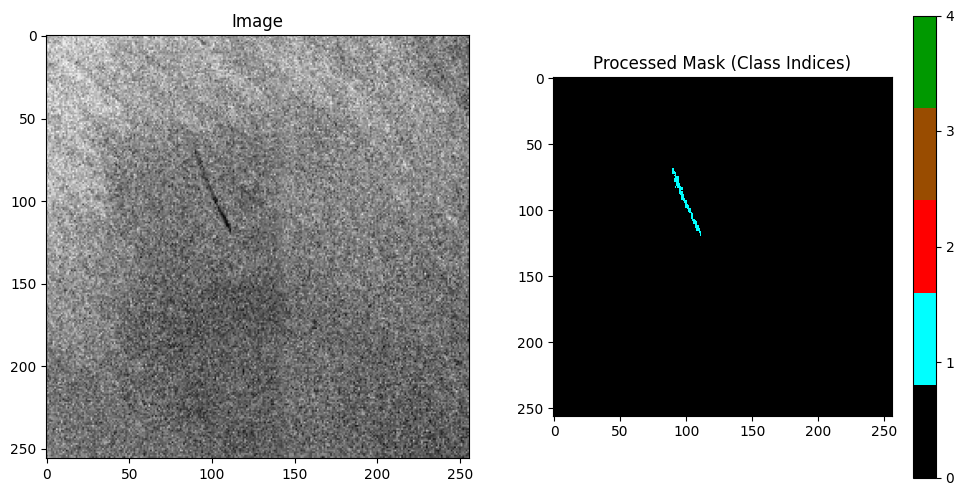

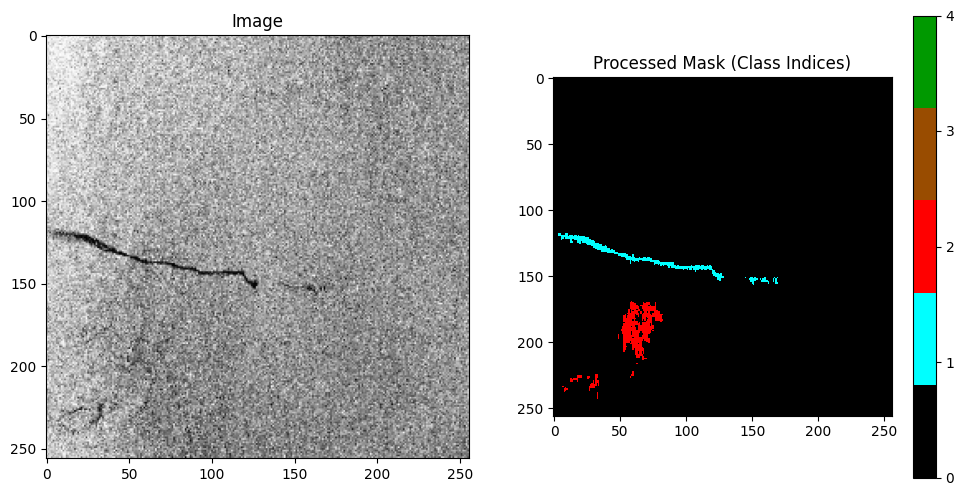

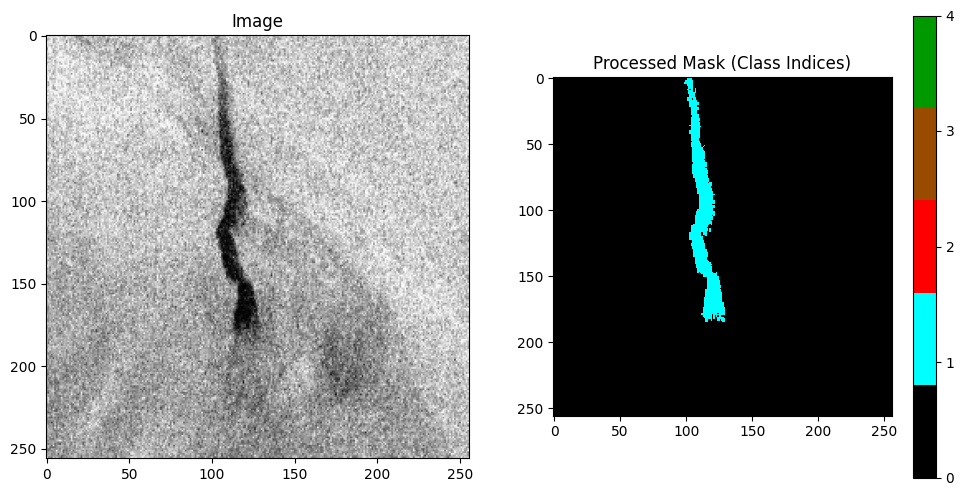

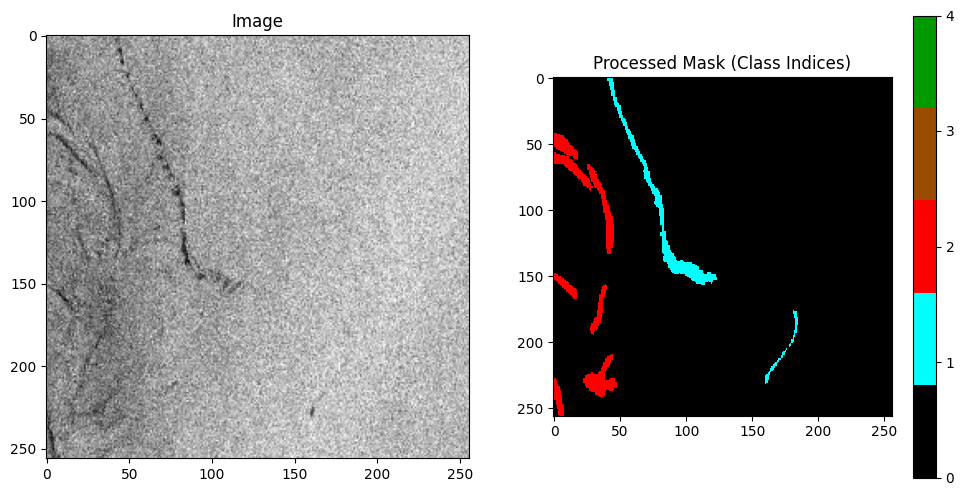

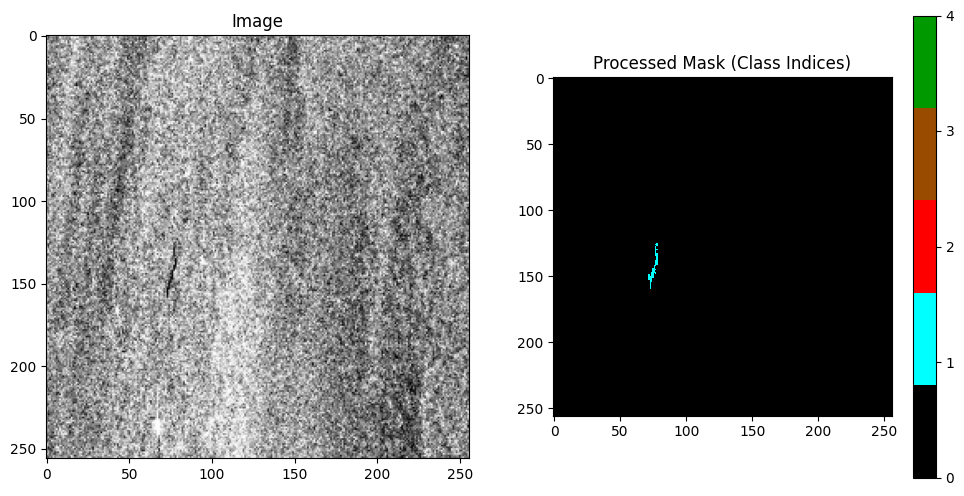

In [37]:
import matplotlib.colors as mcolors

# Scale the color values in colors to the range [0, 1]
scaled_colors = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in colors]

# Define a consistent color map based on the scaled colors
cmap = mcolors.ListedColormap(scaled_colors)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [38]:
train_masks = to_categorical(train_masks, num_classes = 5)

In [39]:
input_shape = (height, width, img_chan)

In [40]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [41]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [42]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


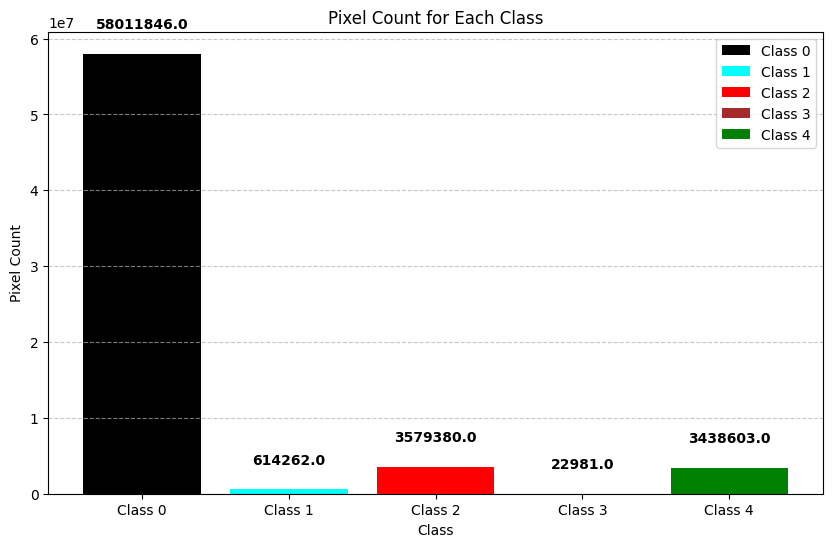

In [43]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [44]:
# Laplacian kernel as constant
def laplacian_filter(x):
    kernel = tf.constant([[[[0.]], [[1.]], [[0.]]],
                          [[[1.]], [[-4.]], [[1.]]],
                          [[[0.]], [[1.]], [[0.]]]], dtype=tf.float32)
    kernel = tf.repeat(kernel, repeats=x.shape[-1], axis=-1)
    kernel = tf.transpose(kernel, [0, 1, 3, 2])  # Shape: (3, 3, in_channels, 1)
    return tf.nn.depthwise_conv2d(x, kernel, strides=[1, 1, 1, 1], padding='SAME')

# Custom Laplacian preprocessing layer
class LaplacianLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return laplacian_filter(inputs)

# U-Net blocks
def conv_block(x, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = MaxPool2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, skip])
    x = conv_block(x, filters)
    return x

# Final U-Net architecture with Laplacian filtering
def build_unet(input_shape=(256, 256, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # Apply Laplacian filter and concatenate with input
    laplacian = LaplacianLayer()(inputs)
    x = concatenate([inputs, laplacian])

    # Encoder
    s1, p1 = encoder_block(x, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    outputs = Conv2D(num_classes, 1, activation=activation)(d4)

    return Model(inputs, outputs, name="LaplacianFilteredUNet")


In [45]:
model = build_unet(input_shape,img_cls)

model.summary()

Model: "LaplacianFilteredUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ laplacian_layer     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (LaplacianLayer)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 6)                │            │ laplacian_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,760 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]  

 Total params: 7,761,093 (29.61 MB)

 Trainable params: 7,761,093 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [48]:
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [49]:
unet_history = model.fit(
    train_images,
    train_masks,
    epochs = epochs,
    batch_size=8,
    verbose = 1,
    validation_split=0.1,
    callbacks=callbacks

)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 502ms/step - accuracy: 0.8606 - loss: 0.6921 - val_accuracy: 0.8967 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.8890 - loss: 0.3998 - val_accuracy: 0.9032 - val_loss: 0.2935 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.8801 - loss: 0.3778 - val_accuracy: 0.9112 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.8905 - loss: 0.3369 - val_accuracy: 0.9187 - val_loss: 0.2695 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.8950 - loss: 0.3246 - val_accuracy: 0.9099 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8876 - loss: 0.3253 - val_accuracy: 0.9127 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accura

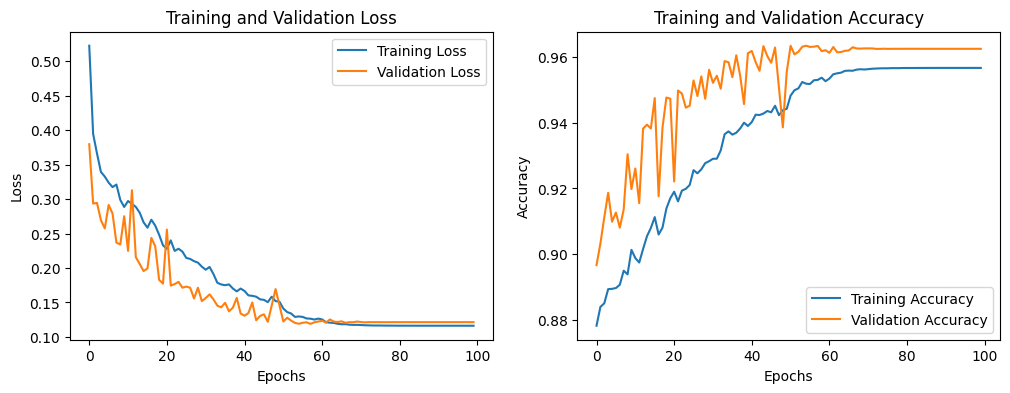

In [50]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


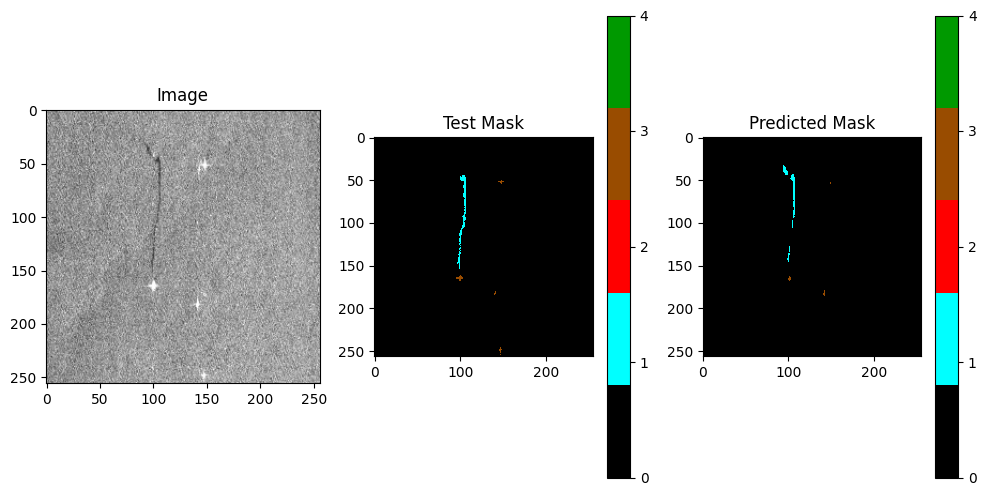

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


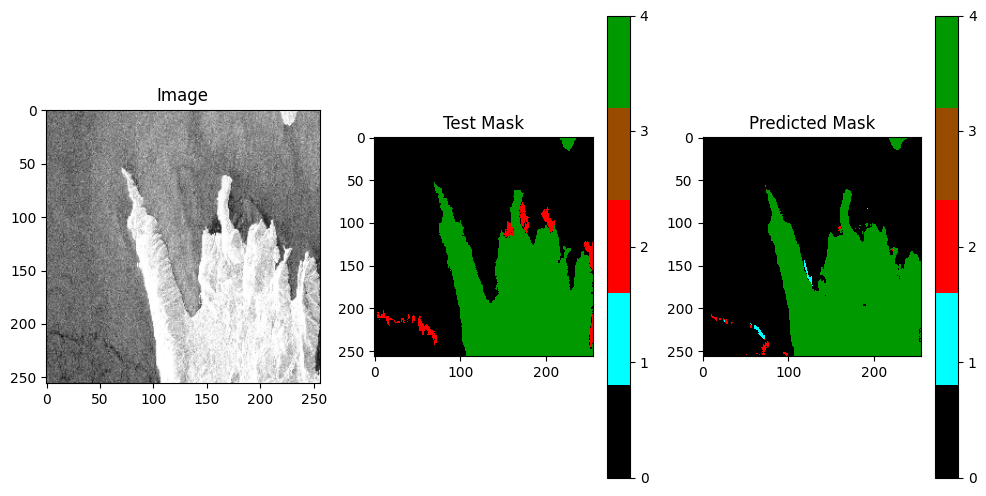

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


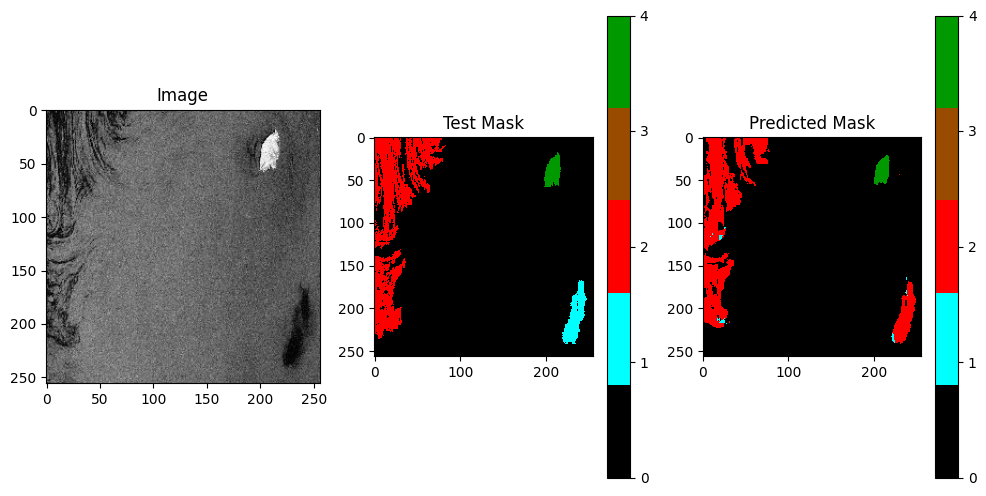

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


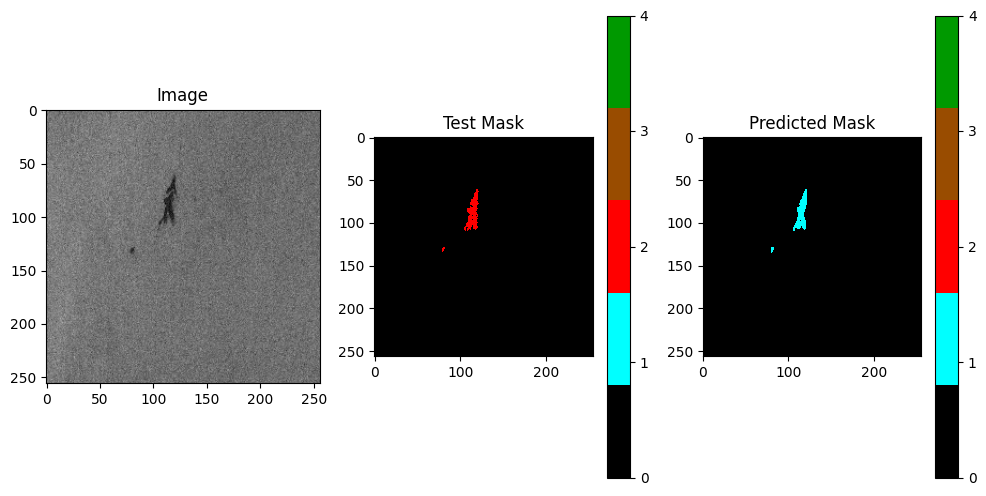

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


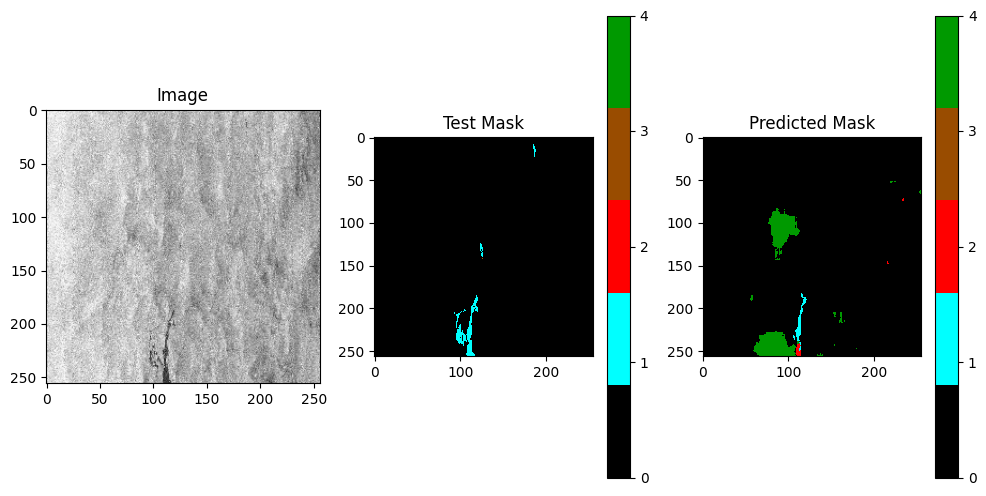

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


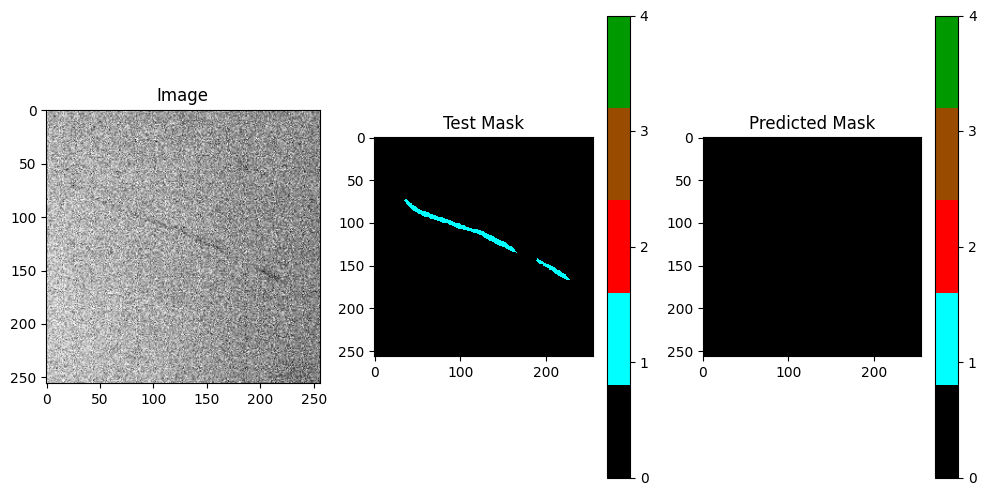

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


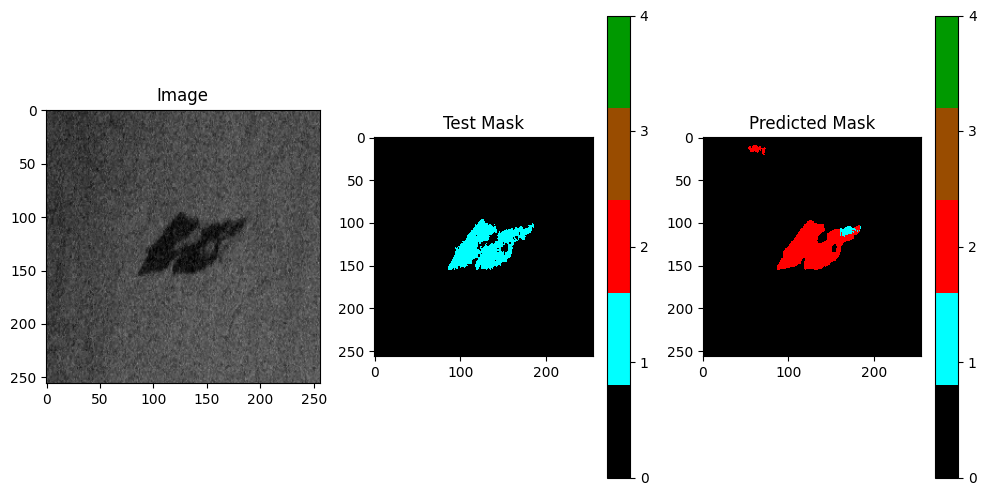

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


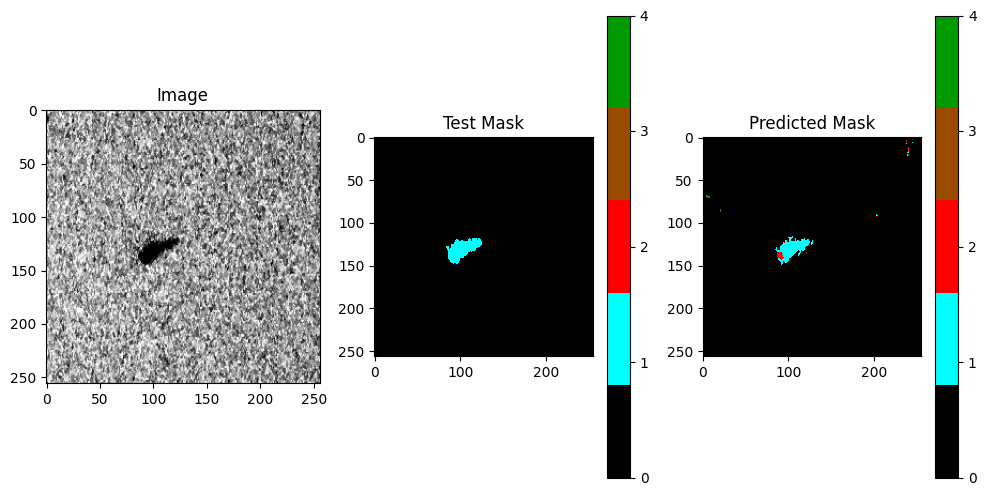

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


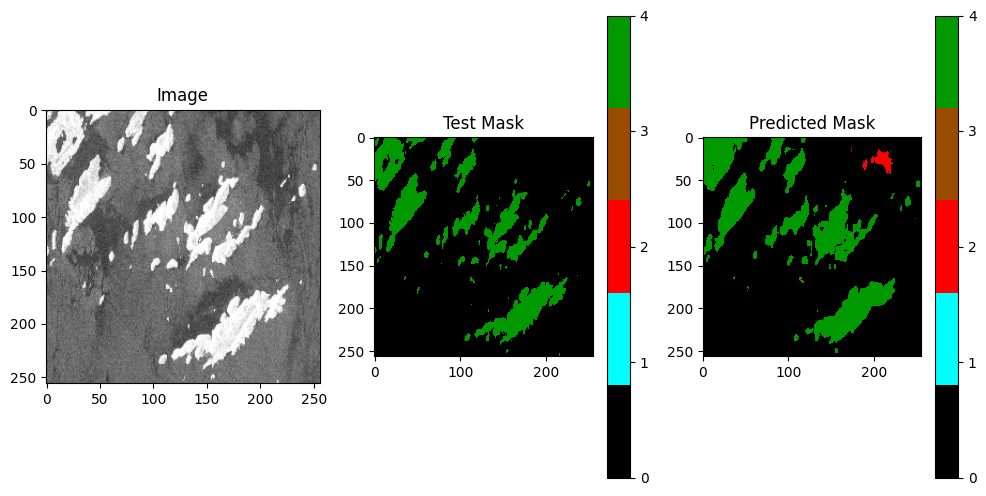

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


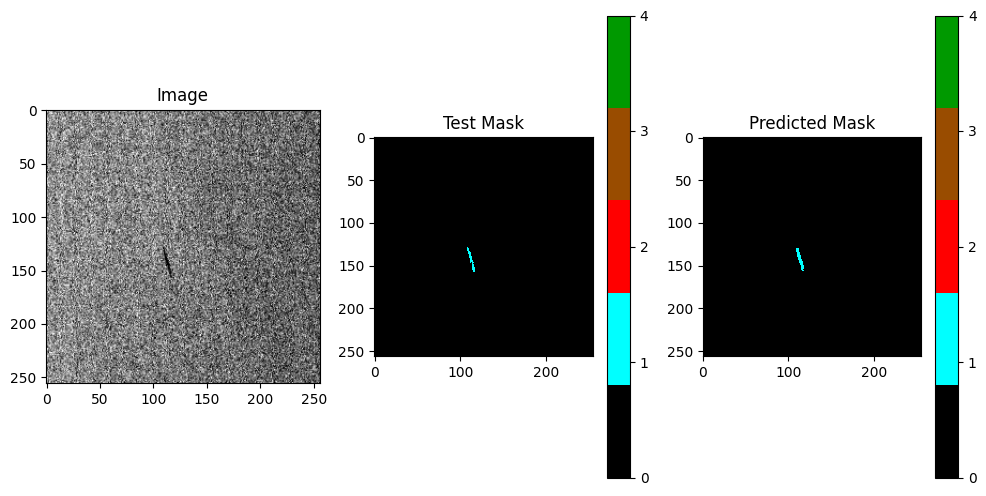

In [51]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, 10)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Test Image
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")

    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Test Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Predicted Mask")

    plt.show()

In [52]:
prediction_unet = model.predict(test_images)

print(test_masks.shape)
print(prediction_unet.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
(110, 256, 256, 1)
(110, 256, 256, 5)


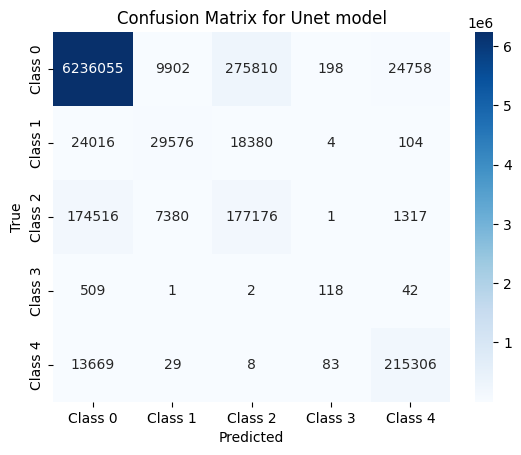

In [53]:

# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [54]:
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

In [55]:

# Calculate precision, recall, and F1 score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9316
Recall: 0.9236
F1 Score: 0.9269


In [56]:
model.save('/content/drive/MyDrive/files/tries/try2i.h5')